# Investigating bimodality driven by a sudden, short-lived decrease in star formation efficiency

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import vice

from multizone.src.yields import J21
from multizone.src.models.utils import exponential
from track_and_mdf import setup_figure, plot_vice_onezone
from apogee_sample import APOGEESample
import paths
from utils import get_bin_centers
from _globals import ONEZONE_DEFAULTS
from colormaps import paultol

In [3]:
# Plot settings
plt.style.use(paths.styles / 'paper.mplstyle')
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', paultol.bright.colors)

Define a simple class which returns a constant SFE timescale at all times
except during a short window where the SFE timescale is much higher.

In [5]:
class tau_star_burst:
    """
    A class declaring the time-dependence of a bursty SFE timescale.

    Attributes
    ----------
    base : float (default: 2.0)
        The initial SFE timescale in Gyr.
    onset : float (default: 4.2)
        The onset time of the sudden change in SFE timescale in Gyr.
    duration : float (default: 0.3)
        The duration of the SFE timescale change in Gyr.
    enhancement : float (default: 10.0)
        The factor to increase the SFE timescale during the burst.
    
    Calling
    -------
    Parameters:
        - time (float) : simulation time in Gyr.
    Returns:
        - float : the SFE timescale in Gyr.
    """
    def __init__(self, base=2, onset=4.2, 
                 duration=0.3, enhancement=10):
        self.base = base
        self.onset = onset
        self.duration = duration
        self.enhancement = enhancement

    def __call__(self, time):
        if time < self.onset:
            return self.base #* PRE_BURST_ENHANCEMENT
        elif time < self.onset + self.duration:
            return self.base * self.enhancement
        else:
            return self.base

In [38]:
# Set up output directory
output_dir = paths.data / 'onezone' / 'sfe_burst'
if not output_dir.exists():
    output_dir.mkdir(parents=True)

# One-zone model parameters
simtime = np.arange(0, 13.21, 0.01)

# Reference: constant tau_star
const_sfe_name = str(output_dir / 'constant')
ifr = exponential(norm=1, timescale=15)
sz = vice.singlezone(
    name = const_sfe_name,
    func = ifr,
    mode = 'ifr',
    **ONEZONE_DEFAULTS
)
sz.tau_star = 2.
sz.run(simtime, overwrite=True)

# SFE burst model 1
sfe_burst1_name = str(output_dir / 'onset03_width03')
tau_star = tau_star_burst(onset=0.3)
sz = vice.singlezone(
    name = sfe_burst1_name,
    func = ifr,
    mode = 'ifr',
    **ONEZONE_DEFAULTS
)
sz.tau_star = tau_star
sz.run(simtime, overwrite=True)

# SFE burst model 2
sfe_burst2_name = str(output_dir / 'onset10_width03')
tau_star = tau_star_burst(onset=1)
sz = vice.singlezone(
    name = sfe_burst2_name,
    func = ifr,
    mode = 'ifr',
    **ONEZONE_DEFAULTS
)
sz.tau_star = tau_star
sz.run(simtime, overwrite=True)

# SFE burst model 3
sfe_burst3_name = str(output_dir / 'onset30_width03')
tau_star = tau_star_burst(onset=3)
sz = vice.singlezone(
    name = sfe_burst3_name,
    func = ifr,
    mode = 'ifr',
    **ONEZONE_DEFAULTS
)
sz.tau_star = tau_star
sz.run(simtime, overwrite=True)

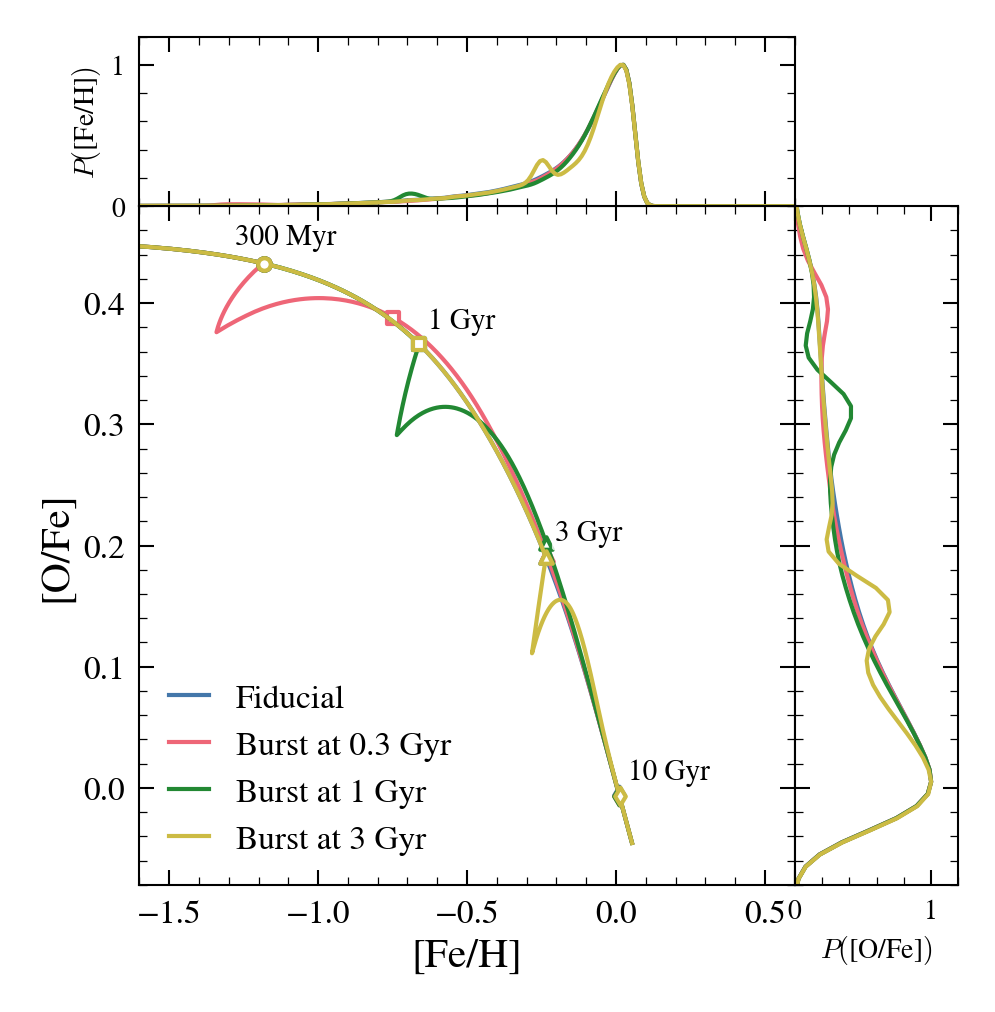

In [39]:
fig, axs = setup_figure(xlim=(-1.6, 0.6), ylim=(-0.08, 0.48))

plot_vice_onezone(const_sfe_name, fig=fig, axs=axs, label='Fiducial', marker_labels=True)
plot_vice_onezone(sfe_burst1_name, fig=fig, axs=axs, label='Burst at 0.3 Gyr')
plot_vice_onezone(sfe_burst2_name, fig=fig, axs=axs, label='Burst at 1 Gyr')
plot_vice_onezone(sfe_burst3_name, fig=fig, axs=axs, label='Burst at 3 Gyr')
axs[0].legend()

plt.show()

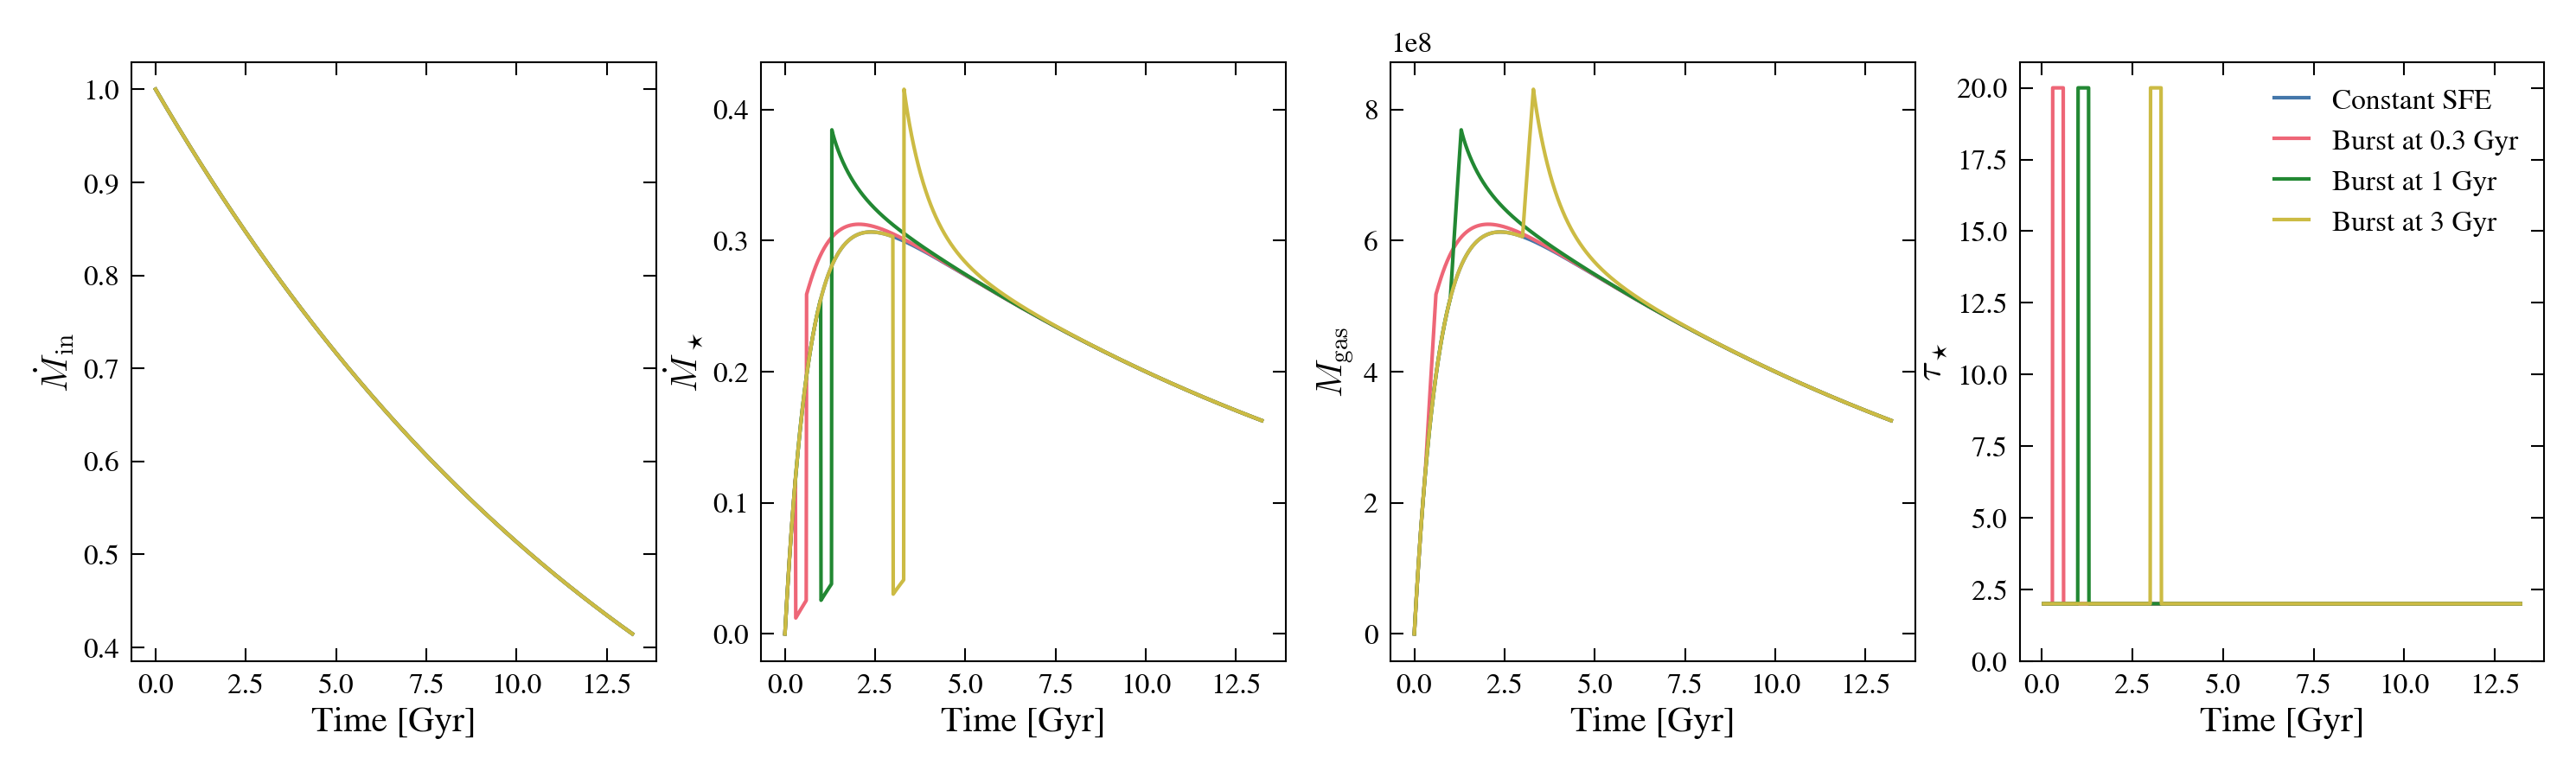

In [40]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
name_list = ['constant', 'onset03_width03', 'onset10_width03', 'onset30_width03']
label_list = ['Constant SFE', 'Burst at 0.3 Gyr', 'Burst at 1 Gyr', 'Burst at 3 Gyr']
for i, name in enumerate(name_list):
    name = str(output_dir / name)
    hist = vice.history(name)
    axs[0].plot(hist['time'], hist['ifr'], '-')
    axs[1].plot(hist['time'], hist['sfr'], '-')
    axs[2].plot(hist['time'], hist['mgas'], '-')
    axs[3].plot(hist['time'][5:], [1e-9 * mg / sfr for mg, sfr in zip(hist['mgas'], hist['sfr'])][5:], '-', label=label_list[i])
    
axs[3].legend()
for ax in axs:
    ax.set_xlabel('Time [Gyr]')
axs[0].set_ylabel(r'$\dot M_{\rm in}$')
axs[1].set_ylabel(r'$\dot M_\star$')
axs[2].set_ylabel(r'$M_{\rm gas}$')
axs[3].set_ylabel(r'$\tau_\star$')
axs[3].set_ylim((0, None))
plt.show()

In [33]:
# SFE burst model 1
sfe_burst1_name = str(output_dir / 'onset30_width01')
tau_star = tau_star_burst(onset=3, duration=0.1)
sz = vice.singlezone(
    name = sfe_burst1_name,
    func = ifr,
    mode = 'ifr',
    **ONEZONE_DEFAULTS
)
sz.tau_star = tau_star
sz.run(simtime, overwrite=True)

# SFE burst model 2
sfe_burst2_name = str(output_dir / 'onset30_width03')
tau_star = tau_star_burst(onset=3, duration=0.3)
sz = vice.singlezone(
    name = sfe_burst2_name,
    func = ifr,
    mode = 'ifr',
    **ONEZONE_DEFAULTS
)
sz.tau_star = tau_star
sz.run(simtime, overwrite=True)

# SFE burst model 3
sfe_burst3_name = str(output_dir / 'onset30_width10')
tau_star = tau_star_burst(onset=3, duration=1.0)
sz = vice.singlezone(
    name = sfe_burst3_name,
    func = ifr,
    mode = 'ifr',
    **ONEZONE_DEFAULTS
)
sz.tau_star = tau_star
sz.run(simtime, overwrite=True)

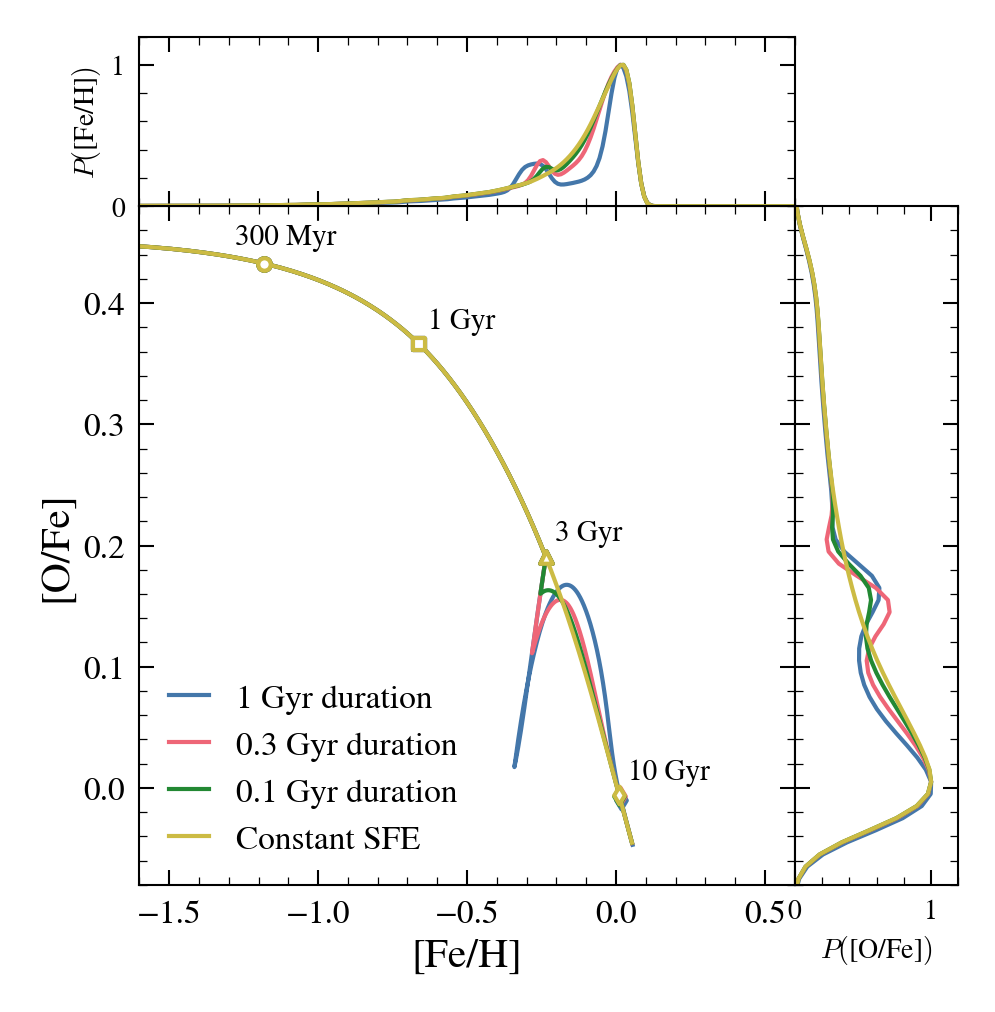

In [35]:
fig, axs = setup_figure(xlim=(-1.6, 0.6), ylim=(-0.08, 0.48))

names = ['onset30_width10', 'onset30_width03', 'onset30_width01', 'constant']
labels = ['1 Gyr duration', '0.3 Gyr duration', '0.1 Gyr duration', 'Constant SFE']
for name, label in zip(names, labels):
    plot_vice_onezone(str(output_dir / name), fig=fig, axs=axs, label=label, 
                      marker_labels=(name=='constant'))
axs[0].legend()

plt.show()

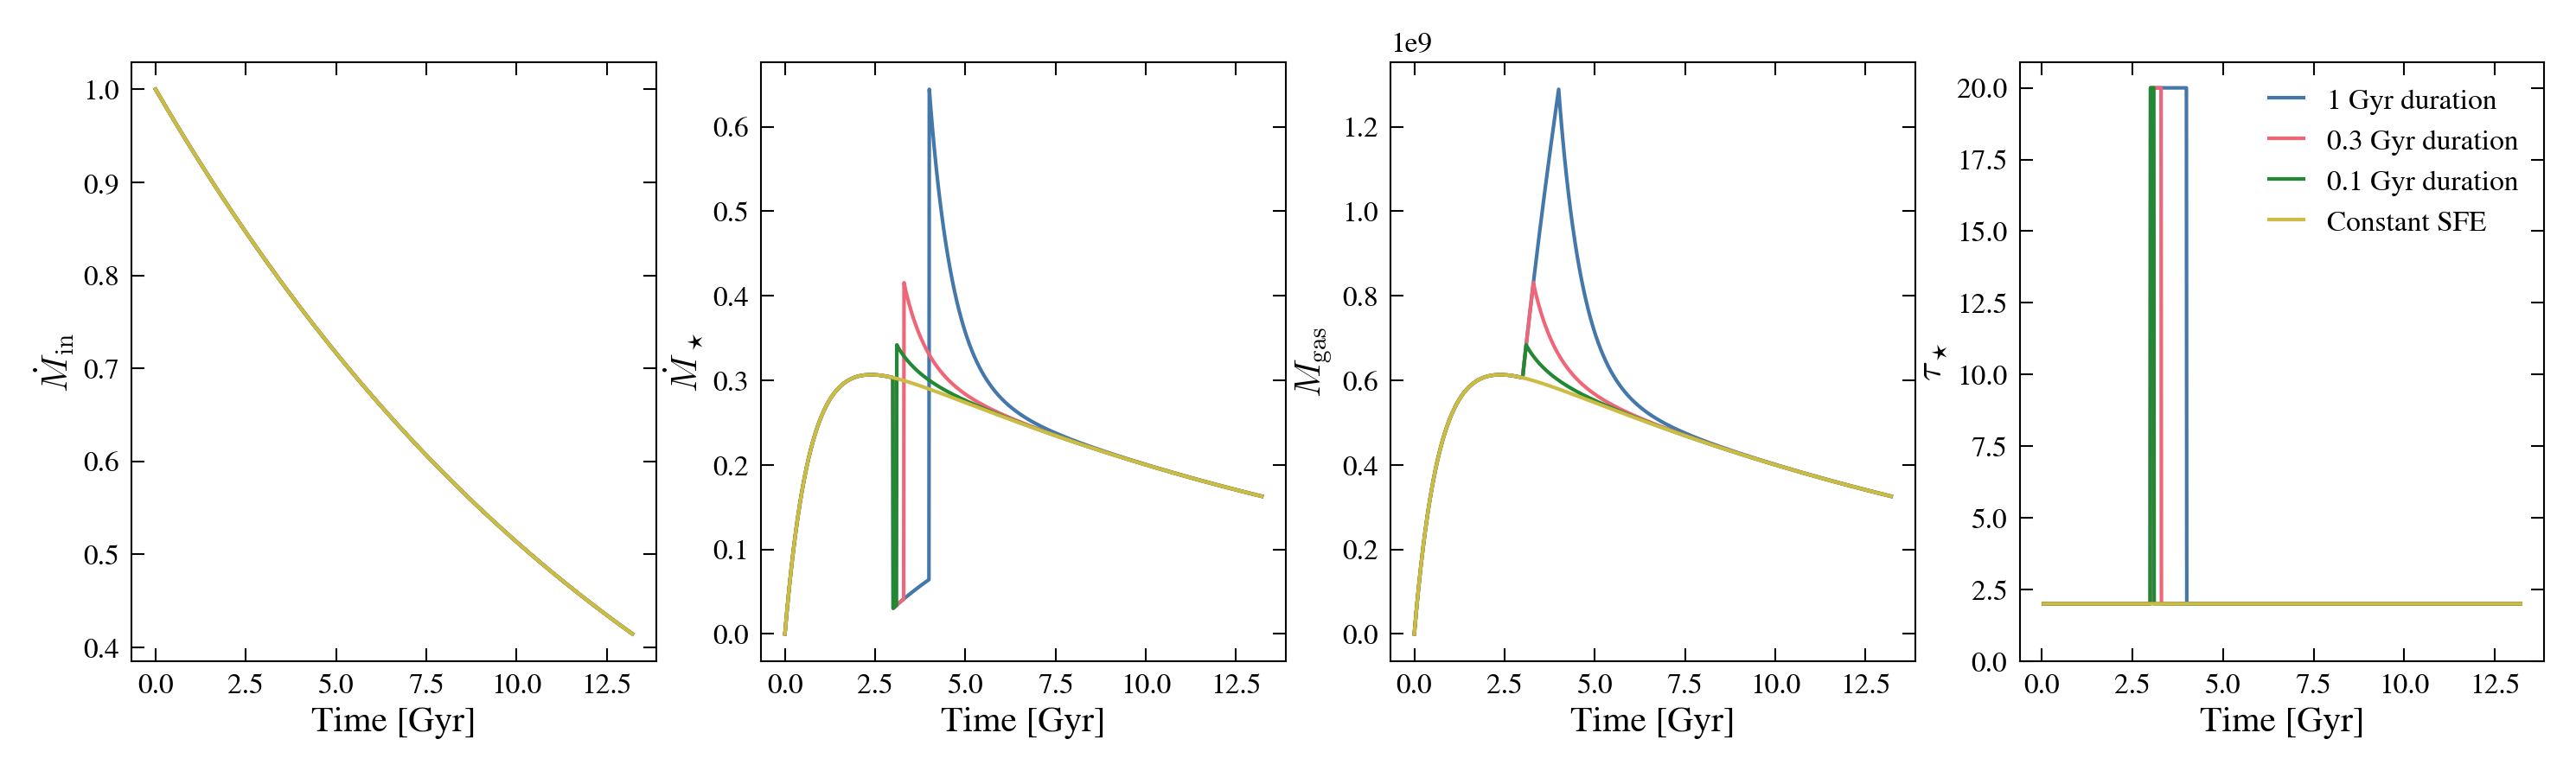

In [36]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
names = ['onset30_width10', 'onset30_width03', 'onset30_width01', 'constant']
labels = ['1 Gyr duration', '0.3 Gyr duration', '0.1 Gyr duration', 'Constant SFE']
for i, name in enumerate(names):
    name = str(output_dir / name)
    hist = vice.history(name)
    axs[0].plot(hist['time'], hist['ifr'], '-')
    axs[1].plot(hist['time'], hist['sfr'], '-')
    axs[2].plot(hist['time'], hist['mgas'], '-')
    axs[3].plot(hist['time'][5:], [1e-9 * mg / sfr for mg, sfr in zip(hist['mgas'], hist['sfr'])][5:], '-', label=labels[i])
    
axs[3].legend()
for ax in axs:
    ax.set_xlabel('Time [Gyr]')
axs[0].set_ylabel(r'$\dot M_{\rm in}$')
axs[1].set_ylabel(r'$\dot M_\star$')
axs[2].set_ylabel(r'$M_{\rm gas}$')
axs[3].set_ylabel(r'$\tau_\star$')
axs[3].set_ylim((0, None))
plt.show()